# How income is affected by the percentage of females in Texas counties

Deciphering if the amount of females in a county affect the median household income. There are more females than males in the state of Texas. Counties can find if and how the number of females to males affects household income. Government policies can support the population better if statistical significance is available. Data science and econometric tools are used in this study to identify a relationship of the percentage of females on the median household income.

According to the U.S. Bureau of Labor Statistics, labor force participation rates in the United States have decreased slightly in the last two decades. In 2000, the labor force participation rate for women 25 to 54 (prime age) was 76.7%, and in 2020 it was 75.1%. For men, it has decreased more as it was 91.6% in 2000 and 87.9% in 2020. Furthermore, women workers in 2014 were earning about 79 percent of what men made annually (Blau and Kahn, 2017). A county in Texas can notice the percentage of females in its population and decide whether it can use policy to support females in improving their relationship to household income or vice-versa with males. Suppose an increase in the percentage of females increases the median household income. In that case, a county can use marketing strategies to encourage females to move to it from other places outside of Texas. Counties can also use the marketing idea vice-versa with males.

PS This study was originally undertaken in November of 2021 and I used Excel to do the data preparation
and STATA to do the regression analysis. I am recreating this study using Python, and delving deeper into EDA, Feature Engineering, and the model building aspect.

## Table of Contents:
1. [Data Preparation](#data-prep)<br>
    A. [Summary Statistics](#ss)<br>
<br>
2. [Exploratory Data Analysis](#eda)<br>
    A. [Correlation Plot](#corr)<br>
    B. [Variable Distribution](#vardist)<br>
<br>
3. [Model Building](#modbuild)<br>
    A. [Features Selection](#feat)<br>
    B. [Model Comparison](#modcomp)<br>
<br>
4. [Conclusion](#concl)<br>
<br>

<a id="data-prep"></a>

## 1| Data Preparation

The linear regression model that I want to start of with is this:
    $$ medianhouseholdincome = \beta_0 + \beta_1 femalepercent + u $$

After this initial model I can add other variables of interest that will help explain the variation in median household income. These other variables at the county level are the poverty rate, the level of education, the owning home rate, the net migration rate, the median age, the total males, the total females, and whether the county voted for President Biden in the 2020 election.

I collected data on counties median household income, poverty rate, and completing college rate from 
the USDA Economic Research Service's [County-level Data Sets](https://www.ers.usda.gov/data-products/county-level-data-sets/). Median household income and the poverty rate is from the U.S. Census Bureau's [Small Area Income and Poverty Estimate (SAIPE)](https://www.census.gov/programs-surveys/saipe.html) program. SAIPE has annual income and poverty statistics estimates for all school districts, counties, and states. Education is from the [American Community Survey](http://www.census.gov/programs-surveys/acs/). The ACS is an ongoing survey that provides information about occupations, educational attainment, veterans, and other topics. The owning home rate and net migration rate data come from the [Atlas of Rural and Small-Town America](https://www.ers.usda.gov/data-products/atlas-of-rural-and-small-town-america/) of United States Department of Agriculture's Economic Research Service. The Atlas provides information about people, jobs, county classifications, income, and veterans. I found the median age from the [Texas Association of Counties](https://imis.county.org/iMIS/CountyInformationProgram/QueriesCIP.aspx). The Texas Association of Counties (TAC) began in 1969 to unite counties and achieve better solutions. I acquired the total females and percentage of females data from the [Texas Demographic Center](https://demographics.texas.gov/data/tpepp/estimates/). The TDC produces annual estimates of the total populations of counties and places in the state. The data on labor force participation rates comes from the United States [Bureau of Labor Statistics](https://www.bls.gov/emp/tables/civilian-labor-force-participation-rate.htm).

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
# Default value of display.max_rows is 10 so at max
# 10 rows will be printed. Set it None to display
# all rows in the dataframe
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Load the csv file
df1 = pd.read_excel('People_Rural Atlas.xlsx')

#Create Texas info dataframe only
df1 = df1[df1["State"] == "TX"]

# Reset index
df1 = df1.reset_index(drop=True)

# Drop first row since it is total of all 254 counties in Texas
df1 = df1.drop([0])

# Reset index
df1 = df1.reset_index(drop=True)

# Uppercase only first letter of County column
df1['County'] = df1['County'].str.title()

# Rename "Dewitt" to "De Witt" from name column
df1['County'] = df1['County'].replace('Dewitt' , 'De Witt', regex=True)

# Rename "McCulloch" to "McCulloch" from name column
df1['County'] = df1['County'].replace('Mcculloch' , 'McCulloch', regex=True)

# Rename "Mclennan" to "McLennan" from name column
df1['County'] = df1['County'].replace('Mclennan' , 'McLennan', regex=True)

# Rename "Mcmullen" to "McMullen" from name column
df1['County'] = df1['County'].replace('Mcmullen' , 'McMullen', regex=True)

In [2]:
# Load the csv file
df2 = pd.read_csv('TDC Sex and Ethnicity 2019.csv')

# Drop first row since it is total of all 254 counties in Texas
df2 = df2.drop([0])

# Reset index
df2 = df2.reset_index(drop=True)

# Remove "COUNTY" from county column
df2['County'] = df2['County'].replace(' COUNTY' , '', regex=True)

# Uppercase only first letter of County column
df2['County'] = df2['County'].str.title()

# Rename "McCulloch" to "McCulloch" from name column
df2['County'] = df2['County'].replace('Mcculloch' , 'McCulloch', regex=True)

# Rename "Mclennan" to "McLennan" from name column
df2['County'] = df2['County'].replace('Mclennan' , 'McLennan', regex=True)

# Rename "Mcmullen" to "McMullen" from name column
df2['County'] = df2['County'].replace('Mcmullen' , 'McMullen', regex=True)

# Create female percentage in county column
df2['femalepct'] = (df2['Total_Female']/df2['Total'])*100

# Create male percentage in county column
df2['malepct'] = (df2['Total_Male']/df2['Total'])*100

In [3]:
# Create a list of counties to be used with later dataframes for easy and correct merging
counties = df2['County'].to_list()

In [4]:
# Load the excel file
df3 = pd.read_excel('TX UnemploymentReport (1).xlsx', skiprows=2)

# Drop first row since it is total of all 254 counties in Texas, and last three rows
df3 = df3.drop([0,255,256,257])

# Reset index
df3 = df3.reset_index(drop=True)

# Rename columns
df3 = df3.rename(columns={"FIPS " : "FIPS", 2019: "unemployment_rate"})

# Add counties column
df3['County'] = counties

In [5]:
# See shape and columns of the dataframe
print(df3.shape)
print(df3.columns)

(254, 16)
Index([                          'FIPS',                           'Name',
                                 '2012',                             2013,
                                   2014,                             2015,
                                   2016,                             2017,
                                   2018,              'unemployment_rate',
                                 '2020', 'Median Household Income (2019)',
                          'Unnamed: 12',    '% of State Median HH Income',
                          'Unnamed: 14',                         'County'],
      dtype='object')


In [6]:
# Load the excel file
df4 = pd.read_excel('est19all.xls', skiprows=3)

#Create Texas info dataframe only
df4 = df4[df4["Postal Code"] == "TX"]

# Reset index
df4 = df4.reset_index(drop=True)

# Drop first row since it is total of all 254 counties in Texas
df4 = df4.drop([0])

# Reset index
df4 = df4.reset_index(drop=True)

# Add counties column
df4['County'] = counties

# Change dtype of columns we care about
df4 = df4.astype({'Poverty Percent, All Ages':'float','Poverty Percent, Age 0-17':'float'})

# Keep only columns we care about
df4 = df4[['County', 'Poverty Percent, All Ages','Poverty Percent, Age 0-17']]

In [7]:
# Load the csv file
df5 = pd.read_csv('ResultsGrid_ExportData (4).csv')

# Add counties column
df5['County1'] = counties

# Keep only columns we care about
df5 = df5[['County1', 'Median Age']]

# Rename column
df5 = df5.rename(columns={'County1':'County'})

In [8]:
# Merge the tables
df = df1.merge(df2, on=['County']).merge(df3, how='inner', on=['County']).merge(df4,how='inner',on=['County']).\
merge(df5,how='inner',on=['County'])

print(df.columns)
print(df.shape)

Index([                                    'FIPS_x',
                                            'State',
                                           'County',
                                'PopChangeRate1819',
                                'PopChangeRate1019',
                                  'TotalPopEst2019',
                             'NetMigrationRate1019',
                            'NaturalChangeRate1019',
       'Net_International_Migration_Rate_2010_2019',
                                'PopChangeRate0010',
       ...
                                               2018,
                                'unemployment_rate',
                                             '2020',
                   'Median Household Income (2019)',
                                      'Unnamed: 12',
                      '% of State Median HH Income',
                                      'Unnamed: 14',
                        'Poverty Percent, All Ages',
                        'Poverty Pe

In [9]:
# See data types of the columns
df.dtypes

FIPS_x                                          int64
State                                          object
County                                         object
PopChangeRate1819                             float64
PopChangeRate1019                             float64
TotalPopEst2019                                 int64
NetMigrationRate1019                          float64
NaturalChangeRate1019                         float64
Net_International_Migration_Rate_2010_2019    float64
PopChangeRate0010                             float64
NetMigrationRate0010                          float64
NaturalChangeRate0010                         float64
Immigration_Rate_2000_2010                    float64
PopDensity2010                                float64
Under18Pct2010                                float64
Age65AndOlderPct2010                          float64
WhiteNonHispanicPct2010                       float64
BlackNonHispanicPct2010                       float64
AsianNonHispanicPct2010     

In [10]:
# Shift column 'Median_Household_Income' to first position
first_column = df.pop('Median Household Income (2019)')

# Insert column using insert(position,column_name,first_column) function
df.insert(0, 'Median Household Income (2019)', first_column)

# Create presidental voting column
df['voted_biden'] = 0

# List of counties that voted for Biden
Biden_Counties = ['Bexar','Brooks','Cameron','Culberson','Dallas','Dimmit','Duval','El Paso','Fort Bend',\
                  'Harris','Hays','Hidalgo','Jim Hogg','Maverick','Presidio','Starr','Tarrant','Travis','Webb',\
                  'Willacy','Williamson','Zavala']

# Biden counties receive 1 in the voted_biden column
df.loc[df['County'].isin(Biden_Counties), 'voted_biden'] = 1

# Display values from dataframe
df.tail()

,Median Household Income (2019),FIPS_x,State,County,PopChangeRate1819,PopChangeRate1019,TotalPopEst2019,NetMigrationRate1019,NaturalChangeRate1019,Net_International_Migration_Rate_2010_2019,PopChangeRate0010,NetMigrationRate0010,NaturalChangeRate0010,Immigration_Rate_2000_2010,PopDensity2010,Under18Pct2010,Age65AndOlderPct2010,WhiteNonHispanicPct2010,BlackNonHispanicPct2010,AsianNonHispanicPct2010,NativeAmericanNonHispanicPct2010,HispanicPct2010,MultipleRacePct2010,NonHispanicWhitePopChangeRate0010,NonHispanicBlackPopChangeRate0010,NonHispanicAsianPopChangeRate0010,NonHispanicNativeAmericanPopChangeRate0010,HispanicPopChangeRate0010,MultipleRacePopChangeRate0010,WhiteNonHispanicNum2010,BlackNonHispanicNum2010,AsianNonHispanicNum2010,NativeAmericanNonHispanicNum2010,HispanicNum2010,MultipleRaceNum2010,ForeignBornPct,ForeignBornEuropePct,ForeignBornMexPct,NonEnglishHHPct,Ed1LessThanHSPct,Ed2HSDiplomaOnlyPct,Ed3SomeCollegePct,Ed4AssocDegreePct,Ed5CollegePlusPct,AvgHHSize,FemaleHHPct,HH65PlusAlonePct,OwnHomePct,ForeignBornNum,TotalPopACS,ForeignBornAfricaPct,Ed3SomeCollegeNum,Ed2HSDiplomaOnlyNum,Ed1LessThanHSNum,TotalPop25Plus,Ed5CollegePlusNum,TotalOccHU,ForeignBornAsiaPct,Ed4AssocDegreeNum,ForeignBornEuropeNum,NonEnglishHHNum,HH65PlusAloneNum,OwnHomeNum,FemaleHHNum,TotalHH,ForeignBornCentralSouthAmPct,ForeignBornCentralSouthAmNum,ForeignBornCaribPct,ForeignBornCaribNum,ForeignBornAfricaNum,ForeignBornAsiaNum,ForeignBornMexNum,LandAreaSQMiles2010,Age65AndOlderNum2010,TotalPop2010,Under18Num2010,Net_International_Migration_2000_2010,NaturalChangeNum0010,NetMigrationNum0010,TotalPopEst2012,TotalPopEst2013,TotalPopEst2010,TotalPopEst2014,TotalPopEst2011,Net_International_Migration_2010_2019,NaturalChange1019,TotalPopEst2015,TotalPopEst2016,TotalPopEst2017,NetMigration1019,TotalPopEst2018,TotalPopEstBase2010,FIPS_y,Age,Total,Total_Male,Total_Female,NH_White_Total,NH_White_Male,NH_White_Female,NH_Black_Total,NH_Black_Male,NH_Black_Female,NH_Asian_Total,NH_Asian_Male,NH_Asian_Female,NH_Other_Total,NH_Other_Male,NH_Other_Female,Hispanic_Total,Hispanic_Male,Hispanic_Female,femalepct,malepct,FIPS,Name,2012,2013,2014,2015,2016,2017,2018,unemployment_rate,2020,Unnamed: 12,% of State Median HH Income,Unnamed: 14,"Poverty Percent, All Ages","Poverty Percent, Age 0-17",Median Age,voted_biden
249,56945.0,48499,TX,Wood,0.846,8.486,45539,12.905,-4.419,-0.048,14.18,20.31,-2.44,1.346065,65.04,20.32,24.18,84.90,4.65,0.37,0.47,8.46,1.41,11.87,-13.02,126.09,18.56,68.93,48.62,35628,1951,156,198,3551,593,3.570302,0.407970,2.015057,1.108419,15.272524,33.369505,27.577975,7.143300,16.636696,2.59,9.672925,15.148395,80.211993,1584.0,44366,0.121715,8895,10763,4926,32254,5366,16510,0.466574,2304,181.0,183,2501,13243,1597,16510,2.472614,1097.0,0.058603,26.0,54.0,207.0,894.0,645.23,10148,41964,8528,495.5,-896.5,7477.0,42383,42346,41977,42764,42092,-20.0,-1855.0,43117,43753,44263,5417.0,45157,41959,499,All Ages,45084,22573,22511,36874,18239,18635,2315,1233,1082,193,94,99,937,471,466,4765,2536,2229,49.931239,50.068761,48499,"Wood County, TX",7.8,7.3,6.0,5.3,5.3,4.7,4.3,3.9,6.6,NaN,0.889154,NaN,14.3,22.3,48.9,0
250,62636.0,48501,TX,Yoakum,1.432,10.979,8713,0.217,10.763,5.910,7.61,-3.28,11.05,3.347539,9.85,31.74,11.36,39.22,0.70,0.33,0.38,58.66,2.67,-18.53,-40.22,188.89,-18.92,37.44,73.55,3090,55,26,30,4622,210,26.173097,0.000000,24.400417,15.208254,36.507285,26.164580,17.135235,7.490252,12.702647,3.30,6.954528,7.565915,78.028277,2259.0,8631,0.000000,835,1275,1779,4873,619,2617,0.104275,365,0.0,398,198,2042,182,2617,25.906616,2236.0,0.000000,0.0,0.0,9.0,2106.0,799.71,895,7879,2501,243.5,804.0,-238.5,8055,8222,7851,8398,7971,464.0,845.0,8644,8652,8557,17.0,8590,7879,501,All Ages,8829,4426,4403,2625,1280,1345,62,30,32,24,13,11,102,53,49,6016,3050,2966,49.869747,50.130253,48501,"Yoakum County, TX",4.0,3.9,3.1,3.8,4.8,3.6,2.9,2.9,11.9,NaN,0.978015,NaN,10.6,14.9,30.6,0
251,52643.0,48503,TX,Young,0.133,-2.764,18010,-1.091,-1.674,0.459,3.38,1.15,-1.39,1.053457,20.29,24.04,

In [11]:
# Check for missing data
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing.head()

,Total,Percent
Unnamed: 14,254,1.000000
Unnamed: 12,254,1.000000
NonHispanicAsianPopChangeRate0010,12,0.047244
NonHispanicBlackPopChangeRate0010,4,0.015748
NonHispanicNativeAmericanPopChangeRate0010,3,0.011811


In [12]:
# Drop columns with missing data
df = df.dropna(axis=1)

# Check for missing data
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing.head()

,Total,Percent
Median Household Income (2019),0,0.0
TotalPopEst2011,0,0.0
Total_Female,0,0.0
Total_Male,0,0.0
Total,0,0.0


There is no missing data now as those columns have been dropped.

<a id="ss"></a>
### A. Summary Statistics
<br>

unique: the number of unique values<br>
top: the most frequent value<br>
freq: the frequency of the most frequent value

In [13]:
# Create table of summary statistics
summary = df.describe(include='all')
round(summary, 2)

,Median Household Income (2019),FIPS_x,State,County,PopChangeRate1819,PopChangeRate1019,TotalPopEst2019,NetMigrationRate1019,NaturalChangeRate1019,Net_International_Migration_Rate_2010_2019,PopChangeRate0010,NetMigrationRate0010,NaturalChangeRate0010,Immigration_Rate_2000_2010,PopDensity2010,Under18Pct2010,Age65AndOlderPct2010,WhiteNonHispanicPct2010,BlackNonHispanicPct2010,AsianNonHispanicPct2010,NativeAmericanNonHispanicPct2010,HispanicPct2010,MultipleRacePct2010,NonHispanicWhitePopChangeRate0010,HispanicPopChangeRate0010,MultipleRacePopChangeRate0010,WhiteNonHispanicNum2010,BlackNonHispanicNum2010,AsianNonHispanicNum2010,NativeAmericanNonHispanicNum2010,HispanicNum2010,MultipleRaceNum2010,ForeignBornPct,ForeignBornEuropePct,ForeignBornMexPct,NonEnglishHHPct,Ed1LessThanHSPct,Ed2HSDiplomaOnlyPct,Ed3SomeCollegePct,Ed4AssocDegreePct,Ed5CollegePlusPct,AvgHHSize,FemaleHHPct,HH65PlusAlonePct,OwnHomePct,ForeignBornNum,TotalPopACS,ForeignBornAfricaPct,Ed3SomeCollegeNum,Ed2HSDiplomaOnlyNum,Ed1LessThanHSNum,TotalPop25Plus,Ed5CollegePlusNum,TotalOccHU,ForeignBornAsiaPct,Ed4AssocDegreeNum,ForeignBornEuropeNum,NonEnglishHHNum,HH65PlusAloneNum,OwnHomeNum,FemaleHHNum,TotalHH,ForeignBornCentralSouthAmPct,ForeignBornCentralSouthAmNum,ForeignBornCaribPct,ForeignBornCaribNum,ForeignBornAfricaNum,ForeignBornAsiaNum,ForeignBornMexNum,LandAreaSQMiles2010,Age65AndOlderNum2010,TotalPop2010,Under18Num2010,Net_International_Migration_2000_2010,NaturalChangeNum0010,NetMigrationNum0010,TotalPopEst2012,TotalPopEst2013,TotalPopEst2010,TotalPopEst2014,TotalPopEst2011,Net_International_Migration_2010_2019,NaturalChange1019,TotalPopEst2015,TotalPopEst2016,TotalPopEst2017,NetMigration1019,TotalPopEst2018,TotalPopEstBase2010,FIPS_y,Age,Total,Total_Male,Total_Female,NH_White_Total,NH_White_Male,NH_White_Female,NH_Black_Total,NH_Black_Male,NH_Black_Female,NH_Asian_Total,NH_Asian_Male,NH_Asian_Female,NH_Other_Total,NH_Other_Male,NH_Other_Female,Hispanic_Total,Hispanic_Male,Hispanic_Female,femalepct,malepct,FIPS,Name,2012,2013,2014,2015,2016,2017,2018,unemployment_rate,2020,% of State Median HH Income,"Poverty Percent, All Ages","Poverty Percent, Age 0-17",Median Age,voted_biden
count,254.00,254.00,254,254,254.00,254.00,254.00,254.00,254.00,254.00,254.00,254.00,254.00,254.00,254.00,254.00,254.00,254.00,254.00,254.00,254.00,254.00,254.00,254.00,254.00,254.00,254.00,254.00,254.00,254.00,254.00,254.00,254.00,254.00,254.00,254.00,254.00,254.00,254.00,254.00,254.00,254.00,254.00,254.00,254.00,254.00,254.00,254.00,254.00,254.00,254.00,254.00,254.00,254.00,254.00,254.00,254.00,254.00,254.00,254.00,254.00,254.00,254.00,254.00,254.00,254.00,254.00,254.00,254.00,254.00,254.00,254.00,254.00,254.00,254.00,254.00,254.00,254.00,254.00,254.00,254.00,254.00,254.00,254.00,254.00,254.00,254.00,254.00,254.00,254.00,254,254.00,254.00,254.00,254.00,254.00,254.00,254.00,254.00,254.00,254.00,254.00,254.00,254.00,254.00,254.00,254.00,254.00,254.00,254.00,254.00,254,254,254.00,254.00,254.00,254.00,254.00,254.00,254.00,254.00,254.00,254.00,254.00,254.00,254.00,254.00
unique,NaN,NaN,1,254,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,254,254,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,TX,Anderson,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,All Ages,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

There are more men on average in a county than women. Men: 51% and Women: 49%. However, there are more women in total than men.

<a id="eda"></a>

# 2| Exploratory Data Analysis

<a id="corr"></a>
### A. Correlation Plot
<br>

In [14]:
# Measure correlation with median household income in absolute terms for all variables
cor = df.corr(method ='pearson')
cor = round(abs(cor['Median Household Income (2019)']), 2)
cor.sort_values(ascending=False)

Median Household Income (2019)                1.00
% of State Median HH Income                   1.00
Poverty Percent, Age 0-17                     0.84
Poverty Percent, All Ages                     0.82
PopChangeRate1019                             0.67
PopChangeRate0010                             0.63
NetMigrationRate1019                          0.62
NetMigrationRate0010                          0.61
Ed5CollegePlusPct                             0.60
PopChangeRate1819                             0.54
HH65PlusAlonePct                              0.50
HispanicPopChangeRate0010                     0.49
NetMigration1019                              0.49
NonHispanicWhitePopChangeRate0010             0.47
NetMigrationNum0010                           0.46
Ed1LessThanHSPct                              0.46
ForeignBornAsiaPct                            0.44
2015                                          0.43
2018                                          0.41
AsianNonHispanicPct2010        

In [15]:
# Selecting highly correlated features
relevant_features = cor[cor>0.5]
relevant_features

Median Household Income (2019)    1.00
PopChangeRate1819                 0.54
PopChangeRate1019                 0.67
NetMigrationRate1019              0.62
PopChangeRate0010                 0.63
NetMigrationRate0010              0.61
Ed5CollegePlusPct                 0.60
% of State Median HH Income       1.00
Poverty Percent, All Ages         0.82
Poverty Percent, Age 0-17         0.84
Name: Median Household Income (2019), dtype: float64

9 features have a correlation higher than 0.5 in absolute terms with median household income. However, many of these
variables are very similar to each other. Another pearson correlation test is used on only these variables to notice 
if some need to be dropped.

In [16]:
# Import visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(palette='rainbow')

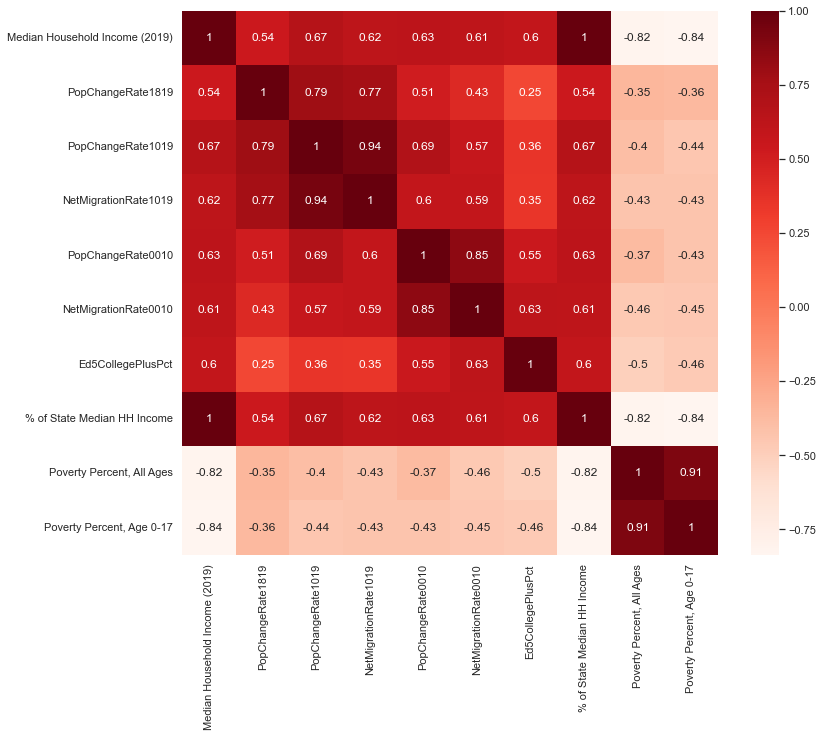

In [17]:
# Create correlation group of 9 variables
correl1 = df[['Median Household Income (2019)','PopChangeRate1819','PopChangeRate1019',\
             'NetMigrationRate1019','PopChangeRate0010','NetMigrationRate0010','Ed5CollegePlusPct',\
             '% of State Median HH Income','Poverty Percent, All Ages', 'Poverty Percent, Age 0-17']]

#Using Pearson Correlation
plt.figure(figsize=(12,10))
cor = correl1.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

PopChangeRate1019 will be kept as a variable of interest since it has the highest correlation with median household income,
while the other PopChangeRate variables will not be used. The NetMigrationRate variables are highly correlated so
NetMigration1019 will be kept since it is more correlated with median household income. Using the same logic, the Poverty
Percent, Age 10-17 will be kept. % of State Median HH Income will not be used since its correlation with median
household income is 1.

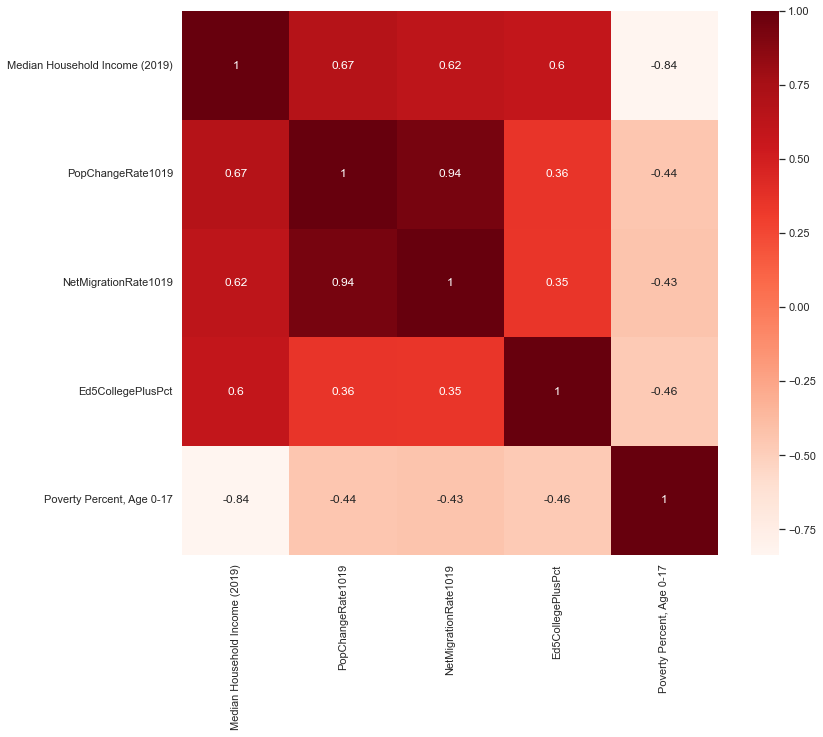

In [18]:
# Create correlation group of 4 variables
correl2 = df[['Median Household Income (2019)','PopChangeRate1019','NetMigrationRate1019','Ed5CollegePlusPct',\
              'Poverty Percent, Age 0-17']]

# Using Pearson Correlation
plt.figure(figsize=(12,10))
cor = correl2.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

Once again, a correlation test is used to let us know if there is high correlation among the independent variables. There
is a correlation of near 1 for PopChangeRate1019 and NetMigrationRate1019, and we will keep the variable with the 
higher correlation with median household income, which is PopChangeRate1019.

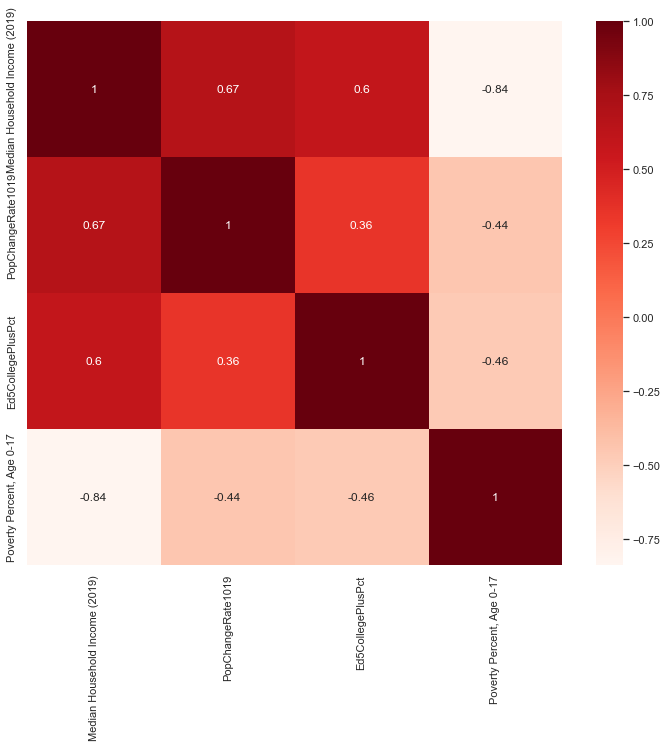

In [19]:
# Create correlation group of 3 variables
correl3 = df[['Median Household Income (2019)','PopChangeRate1019','Ed5CollegePlusPct',\
              'Poverty Percent, Age 0-17']]

# Using Pearson Correlation
plt.figure(figsize=(12,10))
cor = correl3.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

There is no correlation at or above 0.5 among the independent variables. These variables will be used during the model
building section.

<a id="vardist"></a>
### B. Variable Distribution
<br>

Since the amount of females in a county is a percentage, using log transformations of key variables is enticing for the 
sake of interpretation of results. Below, we observe the distributions of some of these variables.

In [20]:
# Create new columns before updates
df['log_femalepct'] = df['log_totalfemale'] = df['log_poverty_allages'] = df['log_medianage'] = df['log_income']\
= df['log_educ'] = df['log_popchange'] = None

# Create log function to return single value 
# passing variable is x
# return log value as log
def log(x):
    log = np.log(x)
    return log

# Call function directly
df['log_femalepct'] = log(df['femalepct'])
df['log_totalfemale'] = log(df['Total_Female'])
df['log_poverty'] = log(df['Poverty Percent, Age 0-17'])
df['log_poverty_allages'] = log(df['Poverty Percent, All Ages'])
df['log_popchange'] = log(df['PopChangeRate1019'])
df['log_educ'] = log(df['Ed5CollegePlusPct'])
df['log_medianage'] = log(df['Median Age'])
df['log_income'] = log(df['Median Household Income (2019)'])

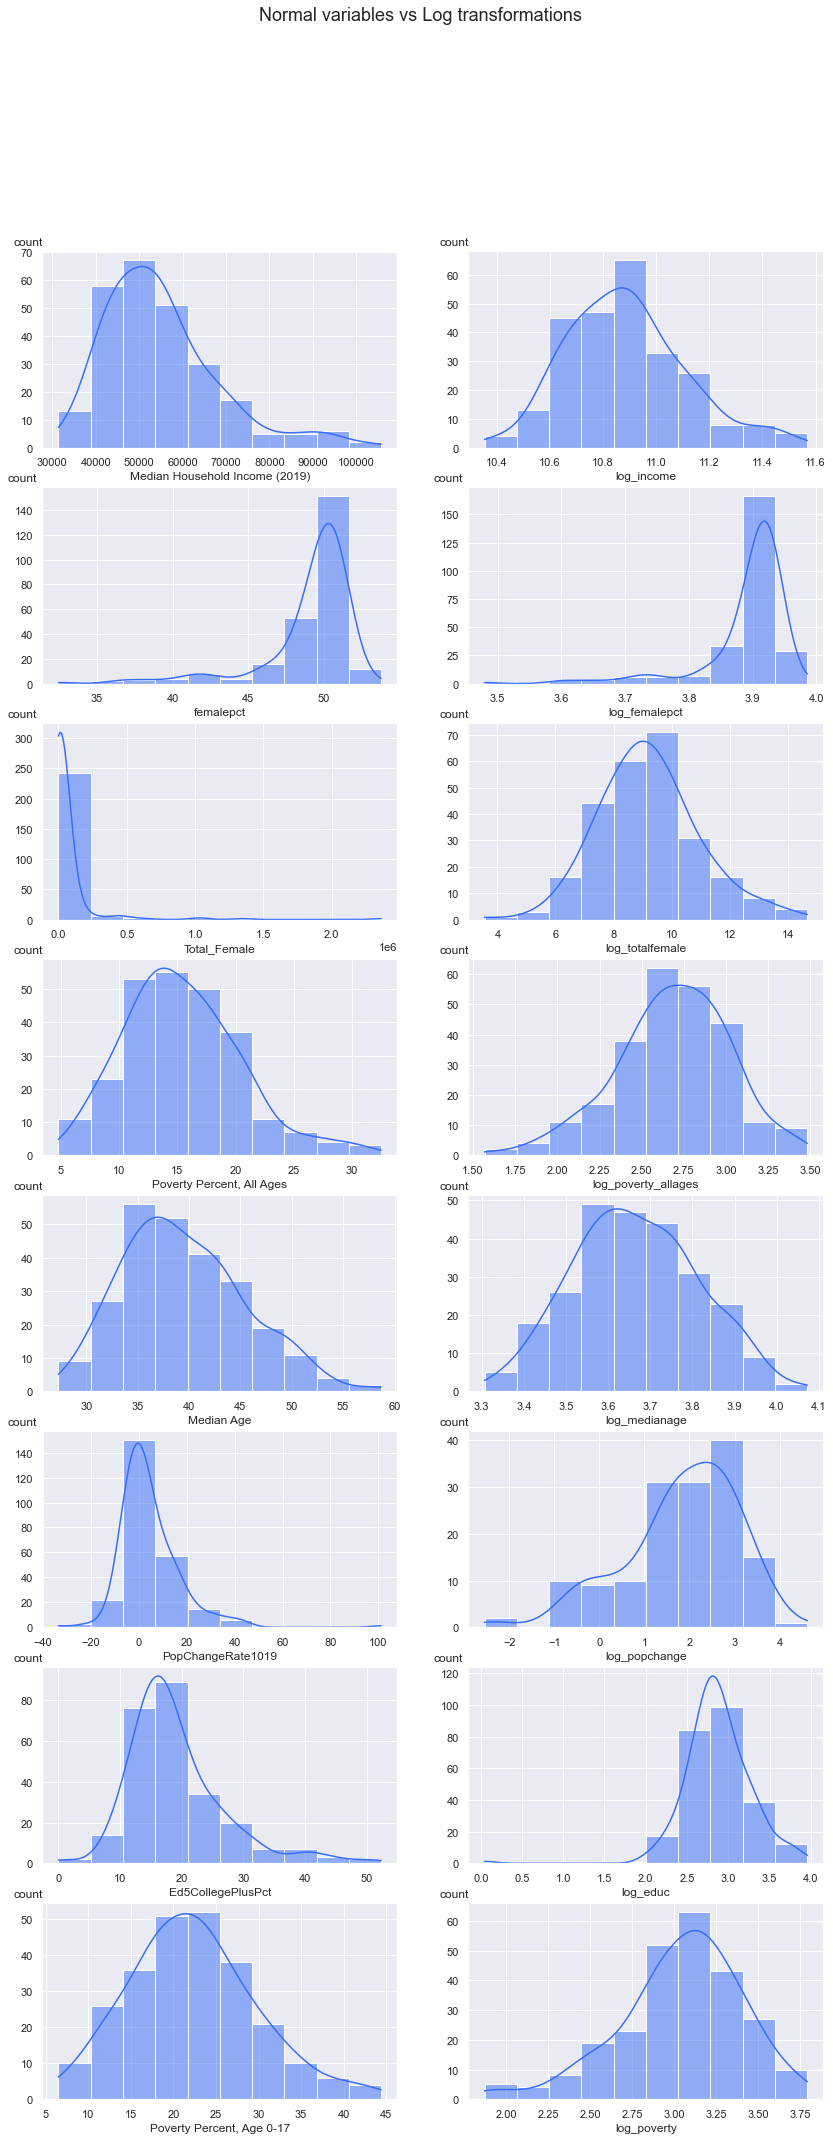

In [21]:
# List of variables and their log transformations
comparisons = df[['Median Household Income (2019)','log_income',\
                   'femalepct','log_femalepct',\
                   'Total_Female','log_totalfemale',\
                   'Poverty Percent, All Ages','log_poverty_allages',\
                   'Median Age','log_medianage',\
                   'PopChangeRate1019','log_popchange',\
                   'Ed5CollegePlusPct', 'log_educ',\
                   'Poverty Percent, Age 0-17','log_poverty']]

# Set figure size
plt.figure(figsize=(14,34))

# Loop to plot each of the columns in the comparison list
for i, col in enumerate(comparisons):
    # Plots are side by side for easy comparison
    ax = plt.subplot(8, 2, i+1)
    
    # Add title
    plt.suptitle('Normal variables vs Log transformations', fontsize=18)
    
    # Make y title horizontal for readbility
    ax.set_ylabel('count', labelpad=-7.5, position=(2.5,1.02), rotation='horizontal')
    
    # Histogram plot with kde to estimate the probability
    sns.histplot(data=df, x=col, edgecolor=None, bins=10, kde=True, ax=ax)

The median age, poverty rate, total females, and median household income variables
become more normally distributed after the log transformation. With these transformations 
a one percent increase in an independent variable would yield an x percent increase in the dependent variable.

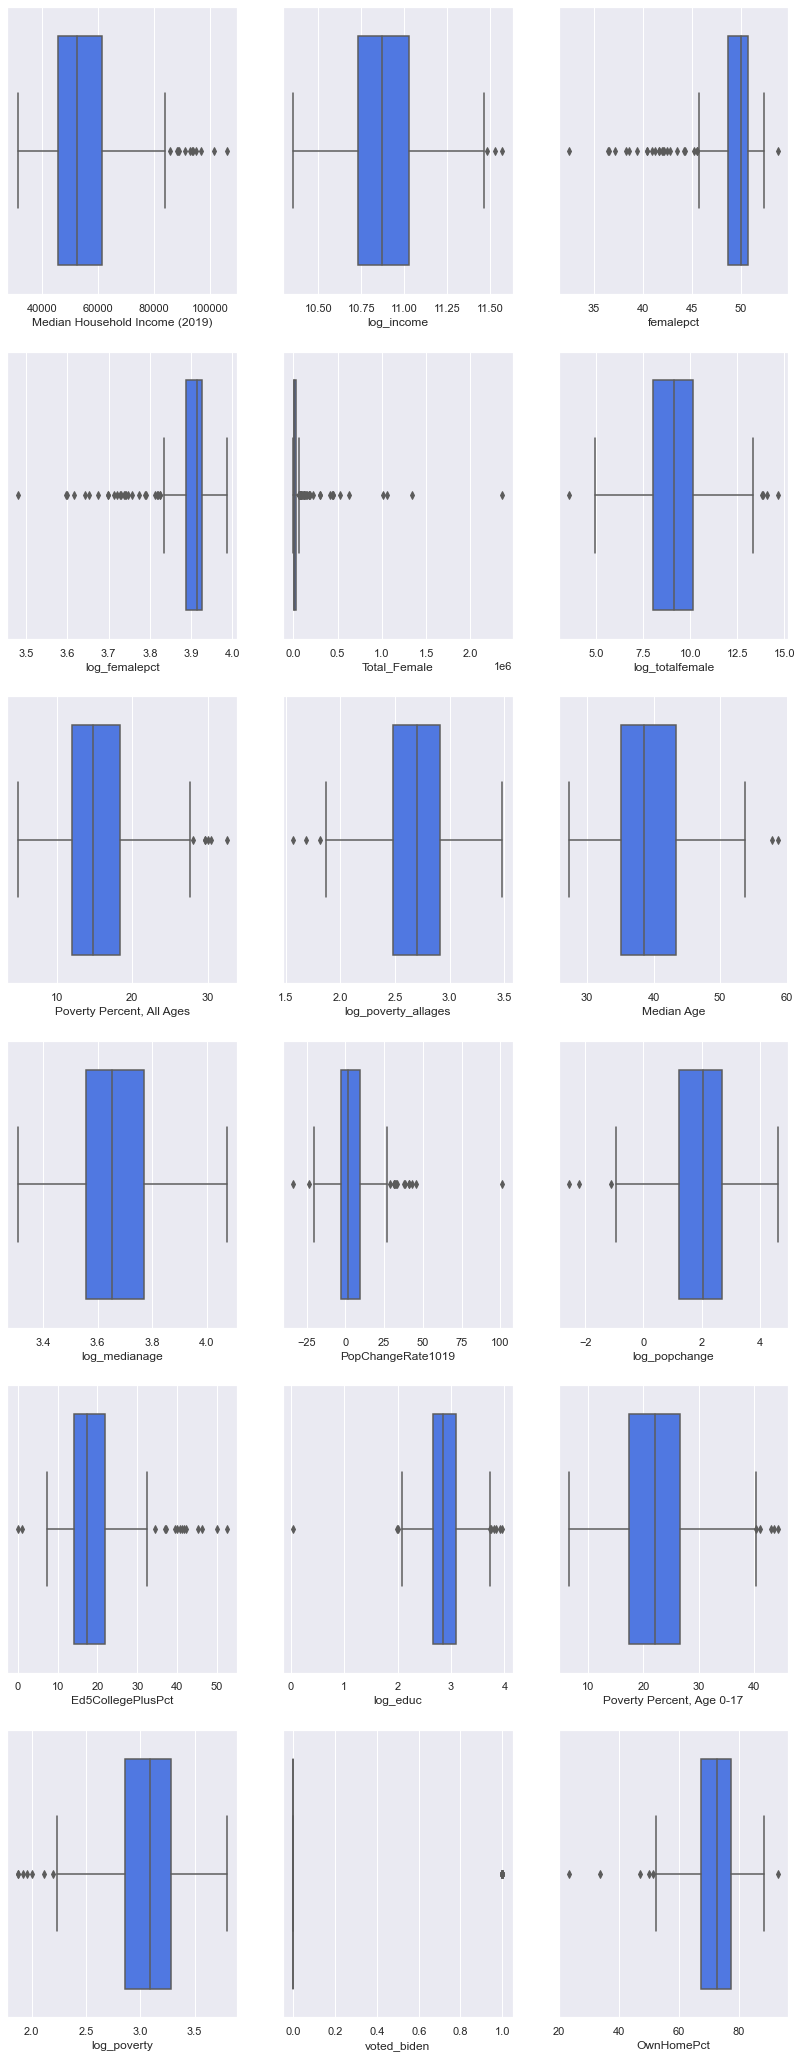

In [22]:
# Subset of key variables
keyvariables = df[['Median Household Income (2019)','log_income',\
                   'femalepct','log_femalepct',\
                   'Total_Female','log_totalfemale',\
                   'Poverty Percent, All Ages','log_poverty_allages',\
                   'Median Age','log_medianage',\
                   'PopChangeRate1019','log_popchange',\
                   'Ed5CollegePlusPct', 'log_educ',\
                   'Poverty Percent, Age 0-17','log_poverty', 'voted_biden','OwnHomePct']]

# Set figure size
plt.figure(figsize=(14,56))

# Loop over numerical columns
for i, col in enumerate(keyvariables):
    # Set the figure dimensions
    ax = plt.subplot(9, 3, i+1)
    
    # Box plot to view range and outliers
    sns.boxplot(data=df, x=col, ax=ax)

Box plots give us the inter-quartile range of the variables. Furthermore, we can see the outliers that are causing the
skewed distributions to the right or to the left.

<a id="modbuild"></a>
## 3| Model Building

<a id="feat"></a>
### A. Features Selection
<br>

In [23]:
# List of all columns
df.columns.to_list()

['Median Household Income (2019)',
 'FIPS_x',
 'State',
 'County',
 'PopChangeRate1819',
 'PopChangeRate1019',
 'TotalPopEst2019',
 'NetMigrationRate1019',
 'NaturalChangeRate1019',
 'Net_International_Migration_Rate_2010_2019',
 'PopChangeRate0010',
 'NetMigrationRate0010',
 'NaturalChangeRate0010',
 'Immigration_Rate_2000_2010',
 'PopDensity2010',
 'Under18Pct2010',
 'Age65AndOlderPct2010',
 'WhiteNonHispanicPct2010',
 'BlackNonHispanicPct2010',
 'AsianNonHispanicPct2010',
 'NativeAmericanNonHispanicPct2010',
 'HispanicPct2010',
 'MultipleRacePct2010',
 'NonHispanicWhitePopChangeRate0010',
 'HispanicPopChangeRate0010',
 'MultipleRacePopChangeRate0010',
 'WhiteNonHispanicNum2010',
 'BlackNonHispanicNum2010',
 'AsianNonHispanicNum2010',
 'NativeAmericanNonHispanicNum2010',
 'HispanicNum2010',
 'MultipleRaceNum2010',
 'ForeignBornPct',
 'ForeignBornEuropePct',
 'ForeignBornMexPct',
 'NonEnglishHHPct',
 'Ed1LessThanHSPct',
 'Ed2HSDiplomaOnlyPct',
 'Ed3SomeCollegePct',
 'Ed4AssocDegreePct

Our first linear regression model will only use the female pct variable. From there we will add other variables
of interest to see what interpretation we can make.

In [24]:
# Import libraries
import statsmodels.api as sm

# Target dependent variable
y = df['Median Household Income (2019)']

<a id="modcomp"></a>
### B. Model Comparison
<br>

**Model 1: Linear Regression $$ medianhouseholdincome = \beta_0 + \beta_1 femalepct + u $$**

In [25]:
# Regression model with just one variable
X = df.femalepct

# Adding a constant column to X
X = sm.add_constant(X)

# Create OLS Linear probability model
ols = sm.OLS(y, X)

# Fit the model
result = ols.fit()

# See results
print(result.summary())

                                  OLS Regression Results                                  
Dep. Variable:     Median Household Income (2019)   R-squared:                       0.007
Model:                                        OLS   Adj. R-squared:                  0.003
Method:                             Least Squares   F-statistic:                     1.731
Date:                            Tue, 28 Jun 2022   Prob (F-statistic):              0.189
Time:                                    16:31:55   Log-Likelihood:                -2771.8
No. Observations:                             254   AIC:                             5548.
Df Residuals:                                 252   BIC:                             5555.
Df Model:                                       1                                         
Covariance Type:                        nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------

On its own, the percentage of females in a county is not statistically significant in explaining the variation of the
median household income. Its current coefficient estimate says that if femalepct increases by one, then the median household income increases by about 360 dollars.

The next models will incorporate variables that have high correlation with the median household income.

**Model 2: Multiple Linear Regression**
$$ medianhouseholdincome = \beta_0 + \beta_1 femalepct + \beta_2 povertypercent,0-17 + u $$

In [26]:
# Two variables
X = df[['femalepct','Poverty Percent, Age 0-17']]

# Adding a constant column to X
X = sm.add_constant(X)

# Create OLS Linear probability model
ols = sm.OLS(y, X)

# Fit the model
result = ols.fit()

# See results
print(result.summary())

                                  OLS Regression Results                                  
Dep. Variable:     Median Household Income (2019)   R-squared:                       0.700
Model:                                        OLS   Adj. R-squared:                  0.697
Method:                             Least Squares   F-statistic:                     292.6
Date:                            Tue, 28 Jun 2022   Prob (F-statistic):           2.54e-66
Time:                                    16:31:55   Log-Likelihood:                -2619.8
No. Observations:                             254   AIC:                             5246.
Df Residuals:                                 251   BIC:                             5256.
Df Model:                                       2                                         
Covariance Type:                        nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.9

Again, female pct is not statistically significant. Poverty percent explains a lot of the variation in household income.

**Model 3**
$$ medianhouseholdincome = \beta_0 + \beta_1 femalepct + \beta_2 povertypercent,0-17 + \beta_3 popchangerate1019 + u $$

In [27]:
# Three variables
X = df[['femalepct','Poverty Percent, Age 0-17', 'PopChangeRate1019']]

# Adding a constant column to X
X = sm.add_constant(X)

# Create OLS Linear probability model
ols = sm.OLS(y, X)

# Fit the model
result = ols.fit()

# See results
print(result.summary())

                                  OLS Regression Results                                  
Dep. Variable:     Median Household Income (2019)   R-squared:                       0.813
Model:                                        OLS   Adj. R-squared:                  0.811
Method:                             Least Squares   F-statistic:                     362.8
Date:                            Tue, 28 Jun 2022   Prob (F-statistic):           9.43e-91
Time:                                    16:31:55   Log-Likelihood:                -2559.6
No. Observations:                             254   AIC:                             5127.
Df Residuals:                                 250   BIC:                             5141.
Df Model:                                       3                                         
Covariance Type:                        nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.9

Femalepct is now significant as it approaches below the 10% threshold of the p-value.

**Model 4**
$$ medianhouseholdincome = \beta_0 + \beta_1 femalepct + \beta_2 povertypercent,0-17 + \beta_3 popchangerate1019
+ \beta_4 ed5collegepluspct + u $$

In [28]:
# Four variables
X = df[['femalepct','Poverty Percent, Age 0-17', 'PopChangeRate1019','Ed5CollegePlusPct']]

# Adding a constant column to X
X = sm.add_constant(X)

# Create OLS Linear probability model
ols = sm.OLS(y, X)

# Fit the model
result = ols.fit()

# See results
print(result.summary())

                                  OLS Regression Results                                  
Dep. Variable:     Median Household Income (2019)   R-squared:                       0.842
Model:                                        OLS   Adj. R-squared:                  0.839
Method:                             Least Squares   F-statistic:                     331.3
Date:                            Tue, 28 Jun 2022   Prob (F-statistic):           2.09e-98
Time:                                    16:31:55   Log-Likelihood:                -2538.5
No. Observations:                             254   AIC:                             5087.
Df Residuals:                                 249   BIC:                             5105.
Df Model:                                       4                                         
Covariance Type:                        nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.9

Femalepct is no longer statistically significantly with Ed5CollegePlusPct. This variable is the percent of people with a 4-year college degree or more, adults 25 and over, from 2015 to 2019.

**Model 5**
$$ medianhouseholdincome = \beta_0 + \beta_1 femalepct + \beta_2 povertypercent,0-17 + \beta_3 popchangerate1019
+ \beta_4 ed5collegepluspct +\beta_5 ownhomepct + u $$

In [29]:
# Five variables
X = df[['femalepct','Poverty Percent, Age 0-17', 'PopChangeRate1019','Ed5CollegePlusPct', 'OwnHomePct']]

# Adding a constant column to X
X = sm.add_constant(X)

# Create OLS Linear probability model
ols = sm.OLS(y, X)

# Fit the model
result = ols.fit()

# See results
print(result.summary())

                                  OLS Regression Results                                  
Dep. Variable:     Median Household Income (2019)   R-squared:                       0.851
Model:                                        OLS   Adj. R-squared:                  0.848
Method:                             Least Squares   F-statistic:                     282.8
Date:                            Tue, 28 Jun 2022   Prob (F-statistic):          3.00e-100
Time:                                    16:31:55   Log-Likelihood:                -2531.1
No. Observations:                             254   AIC:                             5074.
Df Residuals:                                 248   BIC:                             5095.
Df Model:                                       5                                         
Covariance Type:                        nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.9

Every variable except femalepct is statistically significant.

**Model 6**
$$ medianhouseholdincome = \beta_0 + \beta_1 femalepct + \beta_2 povertypercent,0-17 + \beta_3 popchangerate1019 
+ \beta_4 ed5collegepluspct +\beta_5 ownhomepct + \beta_6 medianage + u $$

In [30]:
# Six variables
X = df[['femalepct','Poverty Percent, Age 0-17', 'PopChangeRate1019','Ed5CollegePlusPct', 'OwnHomePct', 'Median Age']]

# Adding a constant column to X
X = sm.add_constant(X)

# Create OLS Linear probability model
ols = sm.OLS(y, X)

# Fit the model
result = ols.fit()

# See results
print(result.summary())

                                  OLS Regression Results                                  
Dep. Variable:     Median Household Income (2019)   R-squared:                       0.853
Model:                                        OLS   Adj. R-squared:                  0.849
Method:                             Least Squares   F-statistic:                     238.1
Date:                            Tue, 28 Jun 2022   Prob (F-statistic):           1.15e-99
Time:                                    16:31:55   Log-Likelihood:                -2529.5
No. Observations:                             254   AIC:                             5073.
Df Residuals:                                 247   BIC:                             5098.
Df Model:                                       6                                         
Covariance Type:                        nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.9

Little change with median age added.

**Model 7**
$$ medianhouseholdincome = \beta_0 + \beta_1 femalepct + \beta_2 povertypercent,0-17 + \beta_3 popchangerate1019 
+ \beta_4 ed5collegepluspct +\beta_5 ownhomepct + \beta_6 medianage + \beta_7 totalfemale + u $$

In [31]:
# Seven variables
X = df[['femalepct','Poverty Percent, Age 0-17', 'PopChangeRate1019','Ed5CollegePlusPct', 'OwnHomePct', 'Median Age',\
        'Total_Female']]

# Adding a constant column to X
X = sm.add_constant(X)

# Create OLS Linear probability model
ols = sm.OLS(y, X)

# Fit the model
result = ols.fit()

# See results
print(result.summary())

                                  OLS Regression Results                                  
Dep. Variable:     Median Household Income (2019)   R-squared:                       0.853
Model:                                        OLS   Adj. R-squared:                  0.849
Method:                             Least Squares   F-statistic:                     203.5
Date:                            Tue, 28 Jun 2022   Prob (F-statistic):           1.71e-98
Time:                                    16:31:55   Log-Likelihood:                -2529.4
No. Observations:                             254   AIC:                             5075.
Df Residuals:                                 246   BIC:                             5103.
Df Model:                                       7                                         
Covariance Type:                        nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.9

The Total_Female variable is not significant, and it does not add more to the R squared of the regression. The next model 
will use Total_Male instead.

**Model 8**
$$ medianhouseholdincome = \beta_0 + \beta_1 femalepct + \beta_2 povertypercent,0-17 + \beta_3 popchangerate1019 
+ \beta_4 ed5collegepluspct +\beta_5 ownhomepct + \beta_6 medianage + \beta_7 totalmale +  u $$

In [32]:
# Seven variables
X = df[['femalepct','Poverty Percent, Age 0-17', 'PopChangeRate1019','Ed5CollegePlusPct', 'OwnHomePct', 'Median Age',\
        'Total_Male']]

# Adding a constant column to X
X = sm.add_constant(X)

# Create OLS Linear probability model
ols = sm.OLS(y, X)

# Fit the model
result = ols.fit()

# See results
print(result.summary())

                                  OLS Regression Results                                  
Dep. Variable:     Median Household Income (2019)   R-squared:                       0.853
Model:                                        OLS   Adj. R-squared:                  0.849
Method:                             Least Squares   F-statistic:                     203.4
Date:                            Tue, 28 Jun 2022   Prob (F-statistic):           1.72e-98
Time:                                    16:31:55   Log-Likelihood:                -2529.4
No. Observations:                             254   AIC:                             5075.
Df Residuals:                                 246   BIC:                             5103.
Df Model:                                       7                                         
Covariance Type:                        nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.9

Once more, Total_Male is behaving in a similar way to Total_Female.

**Model 9**
$$ medianhouseholdincome = \beta_0 + \beta_1 femalepct + \beta_2 povertypercent,0-17 + \beta_3 popchangerate1019 
+ \beta_4 ed5collegepluspct +\beta_5 ownhomepct + \beta_6 medianage + \beta_7 votedbiden + u $$

In [33]:
# Seven variables
X = df[['femalepct','Poverty Percent, Age 0-17', 'PopChangeRate1019','Ed5CollegePlusPct', 'OwnHomePct', 'Median Age',\
        'voted_biden']]

# Adding a constant column to X
X = sm.add_constant(X)

# Create OLS Linear probability model
ols = sm.OLS(y, X)

# Fit the model
result = ols.fit()

# See results
print(result.summary())

                                  OLS Regression Results                                  
Dep. Variable:     Median Household Income (2019)   R-squared:                       0.853
Model:                                        OLS   Adj. R-squared:                  0.849
Method:                             Least Squares   F-statistic:                     204.1
Date:                            Tue, 28 Jun 2022   Prob (F-statistic):           1.21e-98
Time:                                    16:31:55   Log-Likelihood:                -2529.1
No. Observations:                             254   AIC:                             5074.
Df Residuals:                                 246   BIC:                             5102.
Df Model:                                       7                                         
Covariance Type:                        nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.9

The voted_biden variable is not significant. The upcoming model will be only have the femalepct, Total_Female, Poverty Percent, All Ages, and Median Age variables as those were the ones that used in November 2021.

**Model 10**
$$ medianhouseholdincome = \beta_0 + \beta_1 femalepct + \beta_2 totalfemale + \beta_3 povertyrate 
+ \beta_4 medianage + u $$

In [34]:
# Independent variables
X = df[['femalepct','Total_Female','Poverty Percent, All Ages', 'Median Age']]

# Adding a constant column to X
X = sm.add_constant(X)

# Create OLS Linear probability model
ols = sm.OLS(y, X)

# Fit the model
result = ols.fit()

# See results
print(result.summary())

                                  OLS Regression Results                                  
Dep. Variable:     Median Household Income (2019)   R-squared:                       0.741
Model:                                        OLS   Adj. R-squared:                  0.737
Method:                             Least Squares   F-statistic:                     178.2
Date:                            Tue, 28 Jun 2022   Prob (F-statistic):           8.04e-72
Time:                                    16:31:55   Log-Likelihood:                -2601.1
No. Observations:                             254   AIC:                             5212.
Df Residuals:                                 249   BIC:                             5230.
Df Model:                                       4                                         
Covariance Type:                        nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.9

With this model, the percentage of females becomes statistically significant. The R squared drops to .74, but all variables
are significant. The coefficient estimate says that if femalepct increases by one, then the median household
income decreases by about 373 dollars.

A linear regression model suffers from functional form misspecification when it does not account for the relationship
between the dependent and independent variables. If a variable is omitted, it can lead to biased estimators of the betas. 
Ramsey's regression specification error test (RESET) can detect general functional form misspecification. The null 
hypothesis is that the linear model is correctly specified.

In [35]:
import statsmodels.stats.outliers_influence as oi

# RESET test
oi.reset_ramsey(result, degree = 2)

<class 'statsmodels.stats.contrast.ContrastResults'>
<F test: F=array([[134.77422452]]), p=3.58855384728864e-25, df_denom=248, df_num=1>

The p-value is near 0, which suggests that is the linear model is not correctly specified, and the null hypothesis is 
rejected. Log transformations of these variables are used.

This model is of the log-level form so then a Reset test can be performed after.

**Model 11: log-level**
$$ logincome = \beta_0 + \beta_1 femalepct + \beta_2 totalfemale + \beta_3 povertyrate 
+ \beta_4 medianage + u $$

In [36]:
# Independent variables
X = df[['femalepct','Total_Female','Poverty Percent, All Ages', 'Median Age']]

# Adding a constant column to X
X = sm.add_constant(X)

# Create OLS Linear probability model
ols = sm.OLS(df['log_income'], X)

# Fit the model
result = ols.fit()

# See results
print(result.summary())

# RESET test
oi.reset_ramsey(result, degree = 2)

                            OLS Regression Results                            
Dep. Variable:             log_income   R-squared:                       0.800
Model:                            OLS   Adj. R-squared:                  0.796
Method:                 Least Squares   F-statistic:                     248.5
Date:                Tue, 28 Jun 2022   Prob (F-statistic):           1.18e-85
Time:                        16:31:55   Log-Likelihood:                 221.37
No. Observations:                 254   AIC:                            -432.7
Df Residuals:                     249   BIC:                            -415.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

<class 'statsmodels.stats.contrast.ContrastResults'>
<F test: F=array([[56.12582868]]), p=1.1946880731007436e-12, df_denom=248, df_num=1>

The p-value of the Reset test is 0.0000000000011946880731007436, which means that the null hypothesis is rejected. There 
is still functional form misspecification with the log-level model.

**Model 12: log-log**
$$ logincome = \beta_0 + \beta_1 logfemalepct + \beta_2 logtotalfemale + \beta_3 logpovertyrate 
+ \beta_4 logmedianage + u $$

In [37]:
# Independent variables
X = df[['log_femalepct','log_totalfemale','log_poverty_allages','log_medianage']]

# Adding a constant column to X
X = sm.add_constant(X)

# Create OLS Linear probability model
ols = sm.OLS(df['log_income'], X)

# Fit the model
result = ols.fit()

# See results
print(result.summary())

# RESET test
oi.reset_ramsey(result, degree = 2)

                            OLS Regression Results                            
Dep. Variable:             log_income   R-squared:                       0.867
Model:                            OLS   Adj. R-squared:                  0.865
Method:                 Least Squares   F-statistic:                     405.0
Date:                Tue, 28 Jun 2022   Prob (F-statistic):          1.12e-107
Time:                        16:31:55   Log-Likelihood:                 273.18
No. Observations:                 254   AIC:                            -536.4
Df Residuals:                     249   BIC:                            -518.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  14.4884    

<class 'statsmodels.stats.contrast.ContrastResults'>
<F test: F=array([[0.01916932]]), p=0.8899945302988791, df_denom=248, df_num=1>

Now the p-value of the Reset test is 0.8899945302988791, and the null hypothesis cannot be rejected. The log-log model is
preferred on the basis of Reset.

In [38]:
# Import libraries
from statsmodels.compat import lzip
import statsmodels.stats.api as sms

# Conduct the Breusch-Pagan test
names = ['Lagrange multiplier statistic', 'p-value',
         'f-value', 'F p-value']
 
# Get the test result
test_result = sms.het_breuschpagan(result.resid, result.model.exog)

# Zip results
lzip(names, test_result)

[('Lagrange multiplier statistic', 16.048905759041425),
 ('p-value', 0.0029542366100043594),
 ('f-value', 4.198528217267443),
 ('F p-value', 0.0026222464189821918)]

In [39]:
# Import libraries
from statsmodels.stats.diagnostic import het_white

# Perform White test
white_test = het_white(result.resid,  result.model.exog)

# Define labels to use for output of White test
labels = ['Test Statistic', 'Test Statistic p-value', 'F-Statistic', 'F-Test p-value']

# Results of White's test
print(dict(zip(labels, white_test)))

{'Test Statistic': 38.23018932830419, 'Test Statistic p-value': 0.00047913804768600244, 'F-Statistic': 3.024723173082655, 'F-Test p-value': 0.0002600890980813555}


Performing the Breusch-Pagan test and the White test confirms that the log-log model has heteroskedasticity. One more model
is set up using robust standard errors. This method provides a more accurate meausure of the true standard error of the 
regression coefficients.

**Model 13: Robust Standard Errors**
$$ logincome = \beta_0 + \beta_1 logfemalepct + \beta_2 logtotalfemale + \beta_3 logpovertyrate 
+ \beta_4 logmedianage + u $$

In [40]:
# Independent variables
X = df[['log_femalepct','log_totalfemale','log_poverty_allages','log_medianage']]

# Adding a constant column to X
X = sm.add_constant(X)

# Create OLS Linear probability model
ols = sm.OLS(df['log_income'], X)

# Fit the model
result = ols.fit(cov_type = 'HC0')

# See results
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:             log_income   R-squared:                       0.867
Model:                            OLS   Adj. R-squared:                  0.865
Method:                 Least Squares   F-statistic:                     423.4
Date:                Tue, 28 Jun 2022   Prob (F-statistic):          9.10e-110
Time:                        16:31:55   Log-Likelihood:                 273.18
No. Observations:                 254   AIC:                            -536.4
Df Residuals:                     249   BIC:                            -518.7
Df Model:                           4                                         
Covariance Type:                  HC0                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  14.4884    

<a id="concl"></a>
## 4| Conclusion

The initial result showed that an increase in the percentage of females increases the median household income, but it is not statistically significant. Polishing the model by adding the control variable of poverty, ages 0-17 decreased the positive bias in the coefficient estimate of the percentage of females. In models 4 through 9, the coefficient estimate of the percentage of females was finally negative while not being statistically significant as more control variables were included. Up until this point, the independent variables had been chosen intuitively, and through pearson correlation tests.

In model 10, I used the regression that was the most significant when I did this project in November of 2021. That analysis 
was conducted in Stata. The female pct was statistically significant and showed that a one unit increase in the femalepct 
lead to a $373 dollar decrease in the median household income. However, Ramsey's regression specification error test (RESET) detected general functional form misspecification in the level-level and log-level model. The log-log model could no longer reject the null hypothesis of correct specification.


The Breusch-Pagan test and the White test proved that model 12 has heteroskedasticity. This leads to model 13 being the best available with robust standard errors and femalepct being statistically significant.

A statistically significant relationship is possible for the percentage of females with median household income as long as the poverty rate, total female, and median age are control variables. In model 13, a 1% increase in the female percentage in a county leads to a decrease in the median household income by about 0.40%.